In [1]:
import os
import time
from datetime import datetime
import yaml
import numpy as np
from matplotlib import pyplot as plt

def benchmark(core_num:int = 16, node_num:int = 3, data_portion:float = 1.0):
    import re
    import json
    from pyspark.sql import SparkSession
    from operator import add
    from pyspark.sql.types import StructType, StructField, StringType, LongType
    from pyspark.sql.functions import udf, col, size, explode, avg
    from pyspark.sql.types import FloatType, ArrayType
    import re
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    spark_session_name = f"scale_test_{core_num}_{node_num}_{data_portion}"
    spark_session = SparkSession.builder\
            .master("spark://spark-master:7077") \
            .appName(spark_session_name)\
            .config("spark.dynamicAllocation.enabled", False)\
            .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.2.79:9000") \
            .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
            .config("spark.executor.instances", node_num)\
            .config("spark.executor.cores", core_num)\
            .config("spark.cores.max", core_num*node_num)\
            .config("spark.driver.port",9999)\
            .config("spark.blockManager.port",10005)\
            .getOrCreate()
    
    # RDD API
    spark_context = spark_session.sparkContext
    spark_context.setLogLevel("ERROR")
    
    lines = spark_context.textFile(r"hdfs://192.168.2.79:9000/data/reddit.json")
    sampled_lines = lines.sample(withReplacement=False, fraction=data_portion, seed=42)
        
    # Parse each JSON line into a Python dict
    parsed_rdd = sampled_lines.map(lambda line: json.loads(line))

    custom_schema = StructType([
        StructField("content", StringType(), True),          # Comment text
        StructField("summary", StringType(), True),     # Timestamp
        StructField("author", StringType(), True),        # Username
        StructField("subreddit", StringType(), True)      # Subreddit name
    ])
    
    df = spark_session.createDataFrame(parsed_rdd, schema=custom_schema)

    tech_tickers = [
        "AAPL",  # Apple Inc.
        "MSFT",  # Microsoft Corporation
        "GOOGL", "GOOG",  # Alphabet Inc. (Google)
        "AMZN",  # Amazon.com Inc.
        "META",  # Meta Platforms Inc. (Facebook)
        "NVDA",  # NVIDIA Corporation
        "TSLA",  # Tesla Inc.
        "INTC",  # Intel Corporation
        "AMD",  # Advanced Micro Devices Inc.
        "IBM",  # International Business Machines
        "CSCO",  # Cisco Systems Inc.
        "ORCL",  # Oracle Corporation
        "NFLX",  # Netflix Inc.
        "ADBE",  # Adobe Inc.
        "CRM",  # Salesforce Inc.
        "PLTR"  # Palantir Technologies Inc.
    ]

    # Convert the list to a set for faster lookups
    tech_tickers_set = set(tech_tickers)
    
    # Define the UDF
    def extract_tech_tickers(text):
        import re
        if not text:
            return []
        # Split text into words and clean them
        words = re.findall(r'\b\w+\b', text.upper())  # Split into words, ignoring punctuation
        # Check if cleaned word is in the ticker list
        found_tickers = []
        for word in words:
            cleaned_word = re.sub(r'[^A-Z]', '', word)  # Remove non-alphabetic characters
            if cleaned_word in tech_tickers_set:
                found_tickers.append(cleaned_word)
        return list(set(found_tickers))  # Deduplicate
    
    # Register the UDF
    extract_tickers_udf = udf(extract_tech_tickers, ArrayType(StringType()))

    # Apply UDF to the "content" column and filter rows with tickers
    df = df.withColumn("tickers", extract_tickers_udf(col("content"))) \
           .filter(size(col("tickers")) > 0)
    
    # adding wsb/reddit flavour to vader to improve sentiment analysis, score: 4.0 to -4.0
    new_words = {
        'citron': -4.0,  
        'hidenburg': -4.0,        
        'moon': 4.0,
        'highs': 2.0,
        'mooning': 4.0,
        'long': 2.0,
        'short': -2.0,
        'call': 4.0,
        'calls': 4.0,    
        'put': -4.0,
        'puts': -4.0,    
        'break': 2.0,
        'tendie': 2.0,
         'tendies': 2.0,
         'town': 2.0,     
         'overvalued': -3.0,
         'undervalued': 3.0,
         'buy': 4.0,
         'sell': -4.0,
         'gone': -1.0,
         'gtfo': -1.7,
         'paper': -1.7,
         'bullish': 3.7,
         'bearish': -3.7,
         'bagholder': -1.7,
         'stonk': 1.9,
         'green': 1.9,
         'money': 1.2,
         'print': 2.2,
         'rocket': 2.2,
         'bull': 4.0,
         'bear': -4.0,
         'pumping': -1.0,
         'sus': -3.0,
         'offering': -2.3,
         'rip': -4.0,
         'downgrade': -3.0,
         'upgrade': 3.0,     
         'maintain': 1.0,          
         'pump': 1.9,
         'hot': 1.5,
         'drop': -2.5,
         'rebound': 1.5,  
         'crack': 2.5,
        'gang': 2.0,
         'scam': -2.0,
        'chamath': -2.0,
         'snake': -2.0,
        'squezze': 3.0,
         'bag': -4.0,
         'fly': 2.0,     
         'way': 2.0,     
         'high': 2.0,
         'volume': 2.5,
         'low': -2.0,
         'trending': 3.0,
         'upwards': 3.0,
         'prediction': 1.0,     
         'cult': -1.0,     
        'big': 2.0,}

    def custom_sentiment_vader(text):
        if not text:
            return 0.0
        analyzer = SentimentIntensityAnalyzer()
        analyzer.lexicon.update(new_words)
        vs = analyzer.polarity_scores(text)
        return vs['compound']
    
    sentiment_udf = udf(custom_sentiment_vader, FloatType())

    df = df.withColumn("sentiment", sentiment_udf(col("content")))
    # df.collect()

    df_exploded = df.withColumn("ticker", explode(col("tickers")))
    # average the scores
    scores_df = df_exploded.groupBy("ticker").agg(avg("sentiment").alias("avg_sentiment"))
    
    # transform to dictionary
    scores = {row["ticker"]: row["avg_sentiment"] for row in scores_df.collect()}
    
    sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1]))

    # visualization
    # # extract tickers and the corresponding score
    # tickers = list(sorted_scores.keys())
    # sentiments = list(sorted_scores.values())
    
    # # positive: green, negtive: red
    # colors = ["green" if score > 0 else "red" for score in sentiments]
    
    # # plot bar graph
    # plt.figure(figsize=(10, 6))
    # bars = plt.barh(tickers, sentiments, color=colors)
    
    # for bar in bars:
    #     plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
    #              f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10)
    
    # plt.xlabel("Average Sentiment Score")
    # plt.ylabel("Stock Ticker")
    # plt.title("Stock Sentiment Analysis")
    # plt.grid(axis="x", linestyle="--", alpha=0.7)
    # plt.show()

    spark_session.stop()

In [2]:
# data_portion is percentage of the data loaded in the hdfs
def run_test(core_num:int = 16, node_num:int = 3, data_portion:float = 1.0) -> int:
    current_date = str(datetime.now()).split('.')[0]
    print(f'{current_date} - Starting test with | cores: {core_num:2} | nodes: {node_num} | data_portion: {data_portion:2.3}')
    
    start_time = time.time()

    benchmark(core_num, node_num, data_portion)    
    
    end_time = time.time()
    duration = round(end_time - start_time)
    return duration

def plot(duration_data:dict, x_label:str = 'Test Number', x_indices:list = None):
    title = duration_data['title']
    durations = duration_data['tests']
    
    # Create indices for x-axis (test number)
    if x_indices is None:
        test_indices = np.arange(1, len(durations) + 1)
    else:
        test_indices = np.array(x_indices)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(test_indices, durations, s=100, color='blue', alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel('Duration (seconds)')
    ax.set_title(f'Test Durations for {title}')
    
    # Customize x-axis
    ax.set_xticks(test_indices)
    
    # Add annotations with actual duration values
    for i, duration in enumerate(durations):
        minutes = int(duration // 60)
        seconds = int(duration % 60)
        formatted_time = f"{minutes}:{seconds:02d}"
        
        ax.annotate(f"{formatted_time}", 
                   (test_indices[i], durations[i]),
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center')
    
    plt.tight_layout()
    return fig

In [3]:
with open('scalability_test_conf.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
config

{'data_portions': [0.25, 0.5, 0.75, 1.0],
 'cores': [1, 2, 4, 8, 16, 24, 30, 36, 42, 48],
 'nodes': [1, 2, 3]}

> Running tests with different number of cores...
2025-03-12 18:07:25 - Starting test with | cores:  1 | nodes: 3 | data_portion: 1.0


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/12 18:07:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/12 18:07:28 WARN Utils: Service 'sparkDriver' could not bind on port 9999. Attempting port 10000.
25/03/12 18:07:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/12 18:07:29 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.
                                                                                

2025-03-12 18:21:30 - Starting test with | cores:  2 | nodes: 3 | data_portion: 1.0


2025-03-12 18:28:13 - Starting test with | cores:  4 | nodes: 3 | data_portion: 1.0


2025-03-12 18:32:02 - Starting test with | cores:  8 | nodes: 3 | data_portion: 1.0


2025-03-12 18:34:18 - Starting test with | cores: 16 | nodes: 3 | data_portion: 1.0


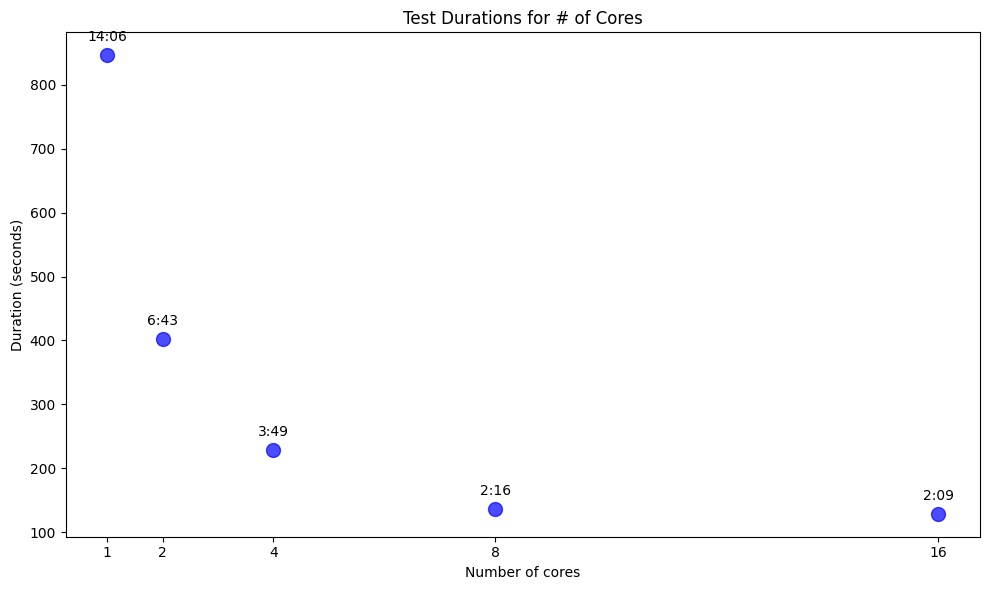

In [4]:
## benchmarking cores
print('> Running tests with different number of cores...')
duration_data = {
    'title': '# of Cores',
    'tests': []
}
for core in config['cores']:
    test_duration = run_test(core_num=core)
    duration_data['tests'].append(test_duration)
fig = plot(duration_data, x_label='Number of cores', x_indices=config['cores'])
fig.savefig('cores_plot')

> Running tests with different number of nodes...
2025-03-12 18:36:27 - Starting test with | cores: 16 | nodes: 1 | data_portion: 1.0


2025-03-12 18:41:22 - Starting test with | cores: 16 | nodes: 2 | data_portion: 1.0


2025-03-12 18:45:39 - Starting test with | cores: 16 | nodes: 3 | data_portion: 1.0


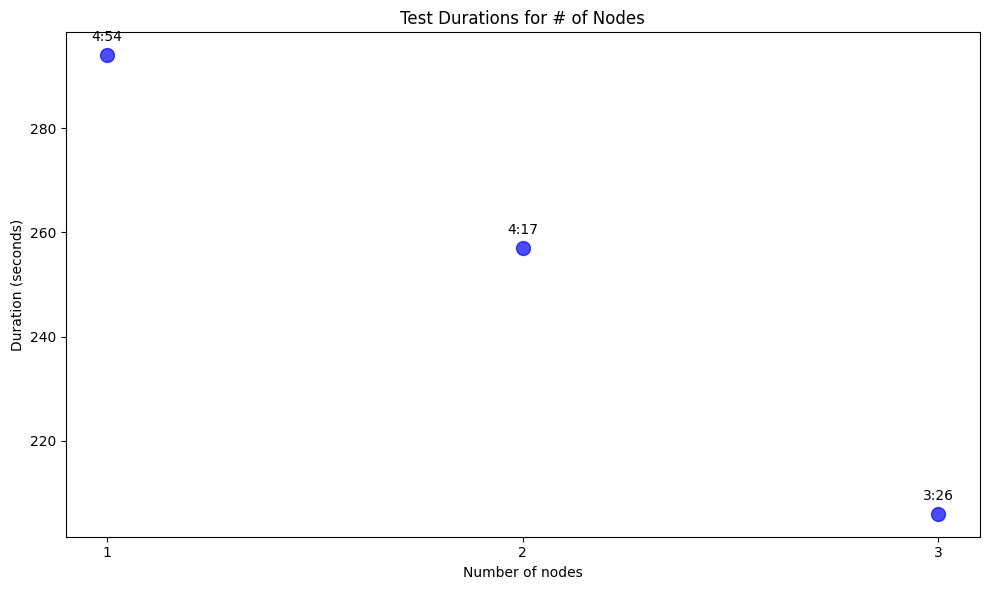

In [5]:
## benchmarking nodes
duration_data = {
    'title': '# of Nodes',
    'tests': []
}
print('> Running tests with different number of nodes...')
for node_num in config['nodes']:
    test_duration = run_test(node_num=node_num)
    duration_data['tests'].append(test_duration)
fig = plot(duration_data, x_label='Number of nodes', x_indices=config['nodes'])
fig.savefig('nodes_plot')

> Running tests with different data sizes...
2025-03-12 18:49:05 - Starting test with | cores: 16 | nodes: 3 | data_portion: 0.25


2025-03-12 18:51:17 - Starting test with | cores: 16 | nodes: 3 | data_portion: 0.5


2025-03-12 18:53:25 - Starting test with | cores: 16 | nodes: 3 | data_portion: 0.75


2025-03-12 18:55:37 - Starting test with | cores: 16 | nodes: 3 | data_portion: 1.0


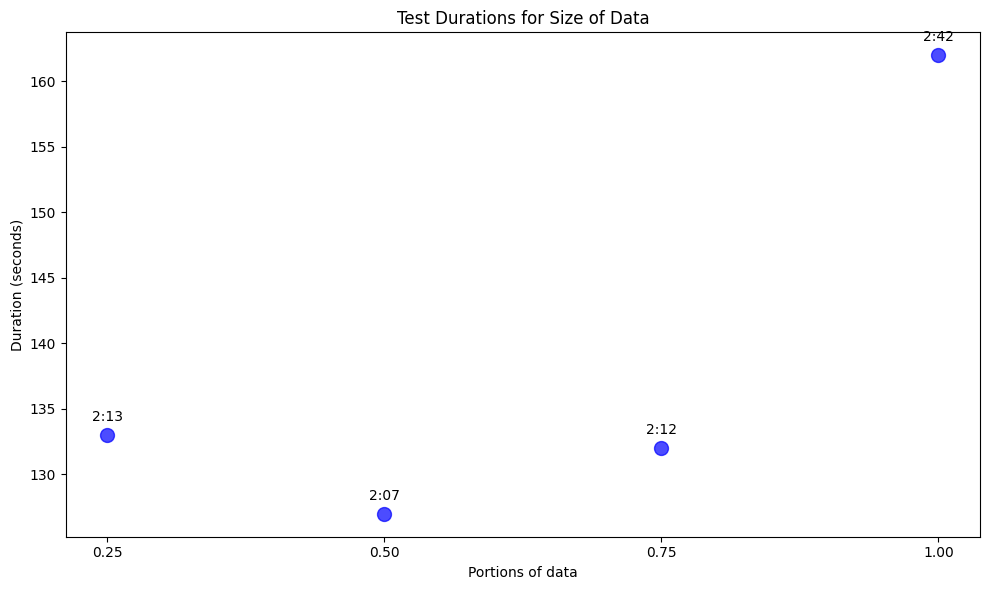

In [6]:
## benchmarking datasize

duration_data = {
    'title': 'Size of Data',
    'tests': []
}
print('> Running tests with different data sizes...')
for data_portion in config['data_portions']:
    test_duration = run_test(data_portion=data_portion)
    duration_data['tests'].append(test_duration)
fig = plot(duration_data, x_label='Portions of data', x_indices=config['data_portions'])    
fig.savefig('data_portions_plot')

> Running tests for weak scaling...
2025-03-12 18:58:20 - Starting test with | cores:  2 | nodes: 3 | data_portion: 0.25


2025-03-12 19:02:15 - Starting test with | cores:  4 | nodes: 3 | data_portion: 0.5


2025-03-12 19:04:45 - Starting test with | cores:  8 | nodes: 3 | data_portion: 1.0


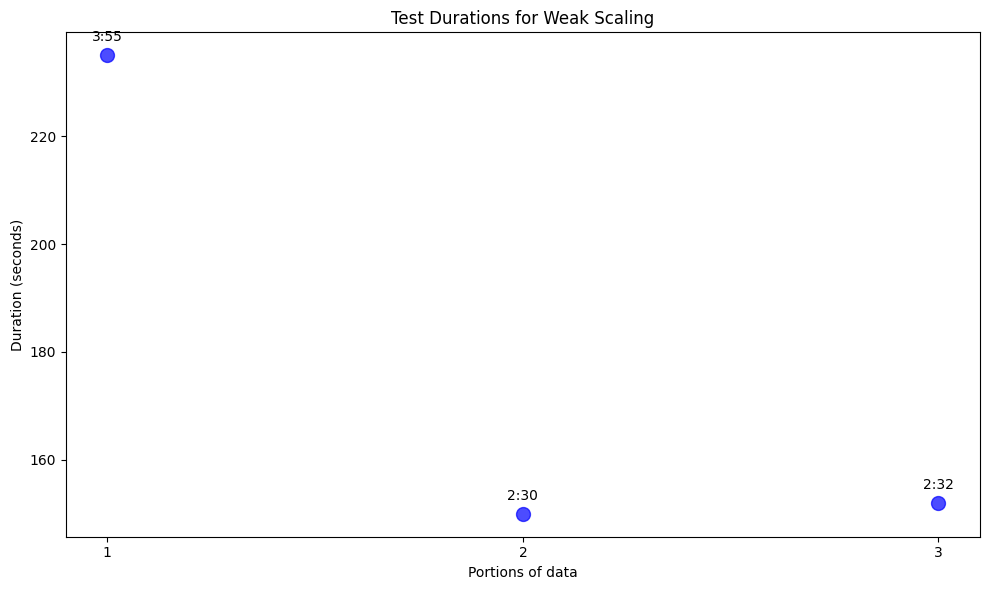

In [7]:
## weak scaling tests

duration_data = {
    'title': 'Weak Scaling',
    'tests': []
}
print('> Running tests for weak scaling...')

base_core_num = 2
base_data_portion = 0.25

for i in range(3):
    test_duration = run_test(core_num=base_core_num, data_portion=base_data_portion)
    duration_data['tests'].append(test_duration)

    base_core_num *= 2
    base_data_portion *= 2
    
fig = plot(duration_data, x_label='Portions of data')    
fig.savefig('weak_scaling_plot')